# TP2

Code pour exécuter le code 

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import h5py

# Cargar el modelo
model = tf.keras.models.load_model('model-B.h5')

# Cargar los nombres de las clases desde el archivo HDF5
with h5py.File('model-B.h5', 'r') as f:
    class_names = [name.decode('utf-8') for name in f.attrs['class_names']]

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Realizar predicciones
    predictions = model.predict(img_array)
    predictions = predictions[0]
    
    # Imprimir les prédictions brutes pour vérification
    print("Predictions brutes : ", predictions)
    
    # Décider si c'est un fursuit ou un animal
    # Utilisez l'indice 0 pour "Fursuit" et l'indice 1 pour "animal"
    class_idx = np.argmax(predictions)
        
    if class_names[class_idx] == 'Fursuit':
        print('Fursuit: oui')
        print('Fursuit: -')
    else:
        print('Fursuit: non')
        # Les espèces commencent après l'indice 2      
        print("Espèce : ", class_names[class_idx])
        

# Exemple de prédiction
predict_image('chien1.jpeg')


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'model-B.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Réseau A

| Composant                | Description                                                             |
|--------------------------|-------------------------------------------------------------------------|
| **Taille de l'image**    | 64 x 64                                                                 |
| **Taille du batch**      | 1100                                                                    |
| **Époques d'entraînement** | 5                                                                     |

Found 26379 files belonging to 11 classes.


C:\Users\jprue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 155s 7s/step - accuracy: 0.1503 - loss: 2.4000 - val_accuracy: 0.1849 - val_loss: 2.2523
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - accuracy: 0.1806 - loss: 2.2650 - val_accuracy: 0.1876 - val_loss: 2.2693
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 194s 7s/step - accuracy: 0.1847 - loss: 2.2420 - val_accuracy: 0.2727 - val_loss: 2.2151
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 133s 7s/step - accuracy: 0.2286 - loss: 2.1775 - val_accuracy: 0.2986 - val_loss: 2.0840
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.2792 - loss: 2.0720 - val_accuracy: 0.3229 - val_loss: 1.9614


5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


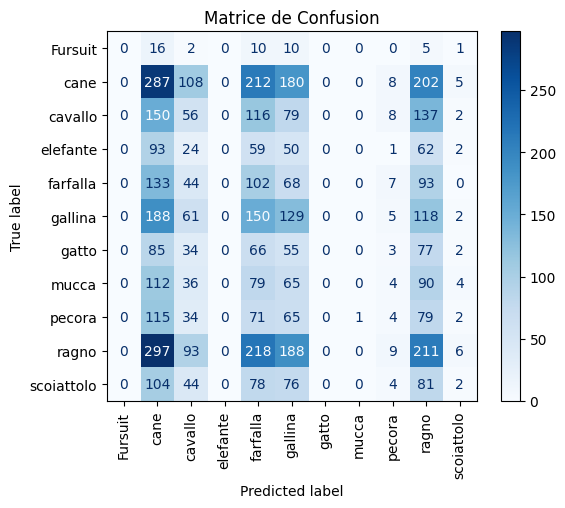

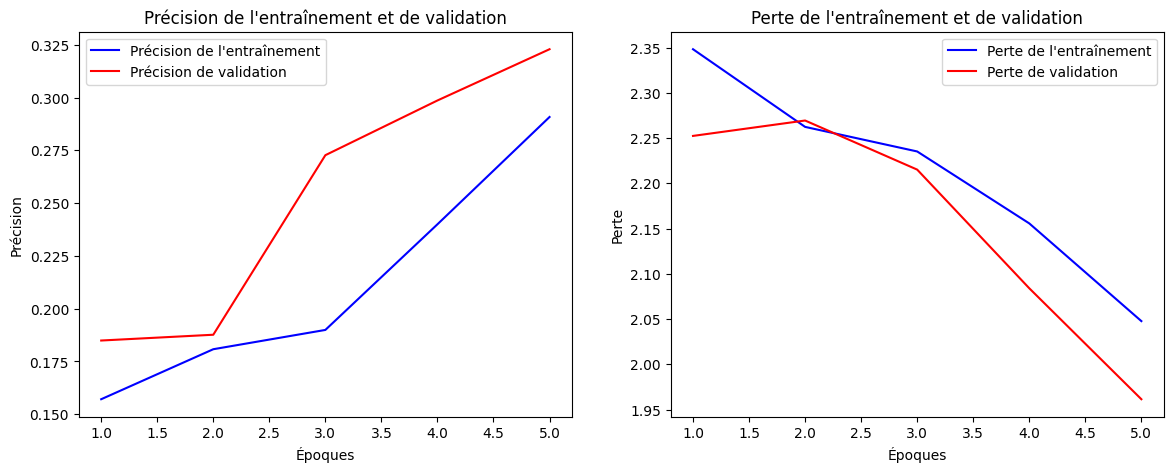

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py

# Fonction de prétraitement des images
def preprocess_image(image, label):
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image, label

# Chargement du dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TP2-images',
    image_size=(64, 64),
    batch_size=1100,
    label_mode='int'
)

# Obtenir les noms des classes
class_names = dataset.class_names

dataset = dataset.map(preprocess_image)

# Nombre de classes (ajustez en fonction du nombre réel de classes)
NUM_CLASSES = len(class_names)

# Révision de l'architecture du modèle avec Dropout
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la première couche de convolution
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la deuxième couche de convolution
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la troisième couche de convolution
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout avant la couche dense finale
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Couche de sortie avec activation softmax
])

# Compilation du modèle
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Fonction pour diviser le dataset
def split_dataset(dataset, split_ratio=0.8):
    dataset_size = len(list(dataset))
    split_index = int(dataset_size * split_ratio)
    train_dataset = dataset.take(split_index)
    val_dataset = dataset.skip(split_index)
    return train_dataset, val_dataset

# Diviser les données
train_dataset, val_dataset = split_dataset(dataset)

# Entraîner le modèle
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

# Sauvegarder le modèle
model1.save('model-A.h5')

# Ajouter les noms des classes dans le fichier HDF5
with h5py.File('model-A.h5', 'a') as f:
    f.attrs['class_names'] = np.string_(class_names)

# Évaluation du modèle
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)
val_predictions = np.argmax(model1.predict(val_dataset), axis=-1)

# Matrice de confusion
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matrice de Confusion')
plt.show()

# Graphique de précision et perte
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision de validation')
plt.title('Précision de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()


### Model B

| Composant                | Description                                                             |
|--------------------------|-------------------------------------------------------------------------|
| **Taille de l'image**    | 64 x 64                                                                 |
| **Taille du batch**      | 32                                                                      |
| **Époques d'entraînement** | 30                                                                   |



Found 26379 files belonging to 11 classes.


C:\Users\jprue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 138s 193ms/step - accuracy: 0.2234 - loss: 2.1980 - val_accuracy: 0.3792 - val_loss: 1.8331
Epoch 2/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 129s 195ms/step - accuracy: 0.3676 - loss: 1.8200 - val_accuracy: 0.4875 - val_loss: 1.5407
Epoch 3/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 129s 195ms/step - accuracy: 0.4487 - loss: 1.6262 - val_accuracy: 0.5484 - val_loss: 1.3563
Epoch 4/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 134s 203ms/step - accuracy: 0.4933 - loss: 1.4912 - val_accuracy: 0.5771 - val_loss: 1.2809
Epoch 5/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 141s 214ms/step - accuracy: 0.5344 - loss: 1.3855 - val_accuracy: 0.6001 - val_loss: 1.1978
Epoch 6/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 148s 224ms/step - accuracy: 0.5612 - loss: 1.3104 - val_accuracy: 0.6347 - val_loss: 1.0983
Epoch 7/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 151s 228ms/step - accuracy: 0.5833 - loss: 1.2249 - val_accuracy: 0.6448 - val_loss: 1.0661
Epoch 8/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 152s 227ms/step - accuracy: 0.6009 -

165/165 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step


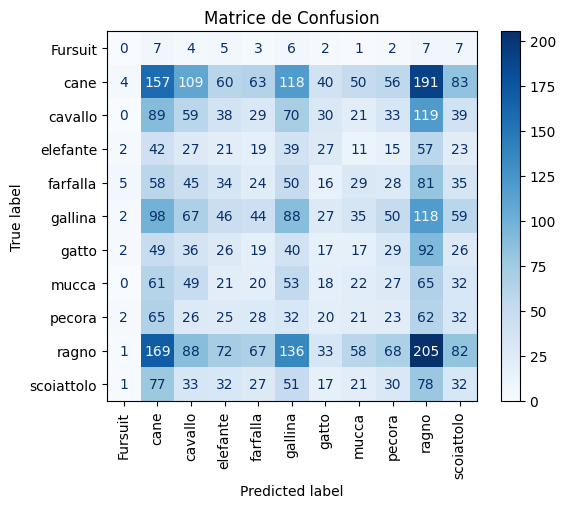

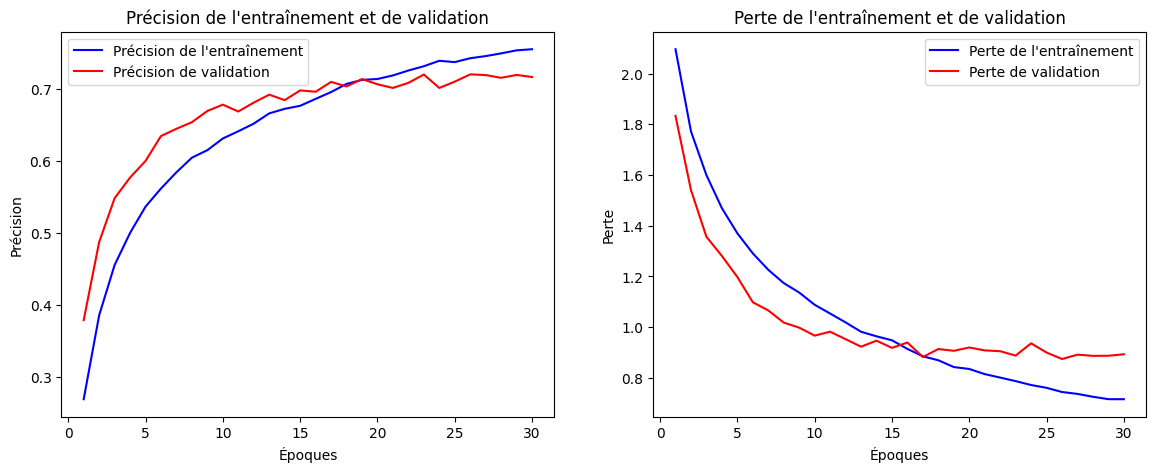

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py

# Fonction de prétraitement des images
def preprocess_image(image, label):
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image, label

# Chargement du dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TP2-images',
    image_size=(64, 64),
    batch_size=32,
    label_mode='int'
)

# Obtenir les noms des classes
class_names = dataset.class_names

dataset = dataset.map(preprocess_image)

# Nombre de classes (ajustez en fonction du nombre réel de classes)
NUM_CLASSES = len(class_names)

# Révision de l'architecture du modèle avec Dropout
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la première couche de convolution
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la deuxième couche de convolution
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la troisième couche de convolution
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout avant la couche dense finale
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Couche de sortie avec activation softmax
])

# Compilation du modèle
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Fonction pour diviser le dataset
def split_dataset(dataset, split_ratio=0.8):
    dataset_size = len(list(dataset))
    split_index = int(dataset_size * split_ratio)
    train_dataset = dataset.take(split_index)
    val_dataset = dataset.skip(split_index)
    return train_dataset, val_dataset

# Diviser les données
train_dataset, val_dataset = split_dataset(dataset)

# Entraîner le modèle
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30
)

# Sauvegarder le modèle
model1.save('model-B.h5')

# Ajouter les noms des classes dans le fichier HDF5
with h5py.File('model-B.h5', 'a') as f:
    f.attrs['class_names'] = np.string_(class_names)

# Évaluation du modèle
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)
val_predictions = np.argmax(model1.predict(val_dataset), axis=-1)

# Matrice de confusion
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matrice de Confusion')
plt.show()

# Graphique de précision et perte
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision de validation')
plt.title('Précision de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()


### Model C

| Hyperparamètre                   | Valeur                                  |
|---------------------------------|-----------------------------------------|
| **Taille de l'image**            | 128x128                                  |
| **Taille du batch**              | 64                                       |
| **Nombre d'époques**             | 20                                       |


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py
from collections import Counter

# Preprocessing function
def preprocess_image(image, label):
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image, label

# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TP2-images',
    image_size=(64, 64),
    batch_size=32,
    label_mode='int'  # Ensure labels are integers
)

# Get class names
class_names = dataset.class_names

# Apply preprocessing
dataset = dataset.map(preprocess_image)

# Function to balance classes
def balance_classes(dataset):
    class_counts = Counter([label.numpy() for _, label in dataset.unbatch()])
    max_count = max(class_counts.values())
    
    balanced_dataset = dataset.unbatch()
    
    for label in range(len(class_names)):  # Use range(len(class_names)) to iterate over class indices
        class_dataset = balanced_dataset.filter(lambda img, lbl: lbl == label)
        augment_factor = max_count // class_counts[label]
        balanced_dataset = balanced_dataset.concatenate(
            class_dataset.repeat(augment_factor)
        )
    
    return balanced_dataset.batch(32)

balanced_dataset = balance_classes(dataset)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

# Apply preprocessing and augmentation
def preprocess_and_augment(image, label):
    image, label = preprocess_image(image, label)
    image = data_augmentation(image)
    return image, label

balanced_dataset = balanced_dataset.map(preprocess_and_augment)

# Split dataset
def split_dataset(dataset, split_ratio=0.8):
    dataset_size = len(list(dataset))
    split_index = int(dataset_size * split_ratio)
    train_dataset = dataset.take(split_index)
    val_dataset = dataset.skip(split_index)
    return train_dataset, val_dataset

train_dataset, val_dataset = split_dataset(balanced_dataset)

# Model architecture
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Compile model with adjusted learning rate
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[reduce_lr, early_stopping]
)

# Save model
model1.save('model-B.h5')

# Add class names to HDF5 file
with h5py.File('model-B.h5', 'a') as f:
    f.attrs['class_names'] = np.string_(class_names)

# Evaluate model
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)
val_predictions = np.argmax(model1.predict(val_dataset), axis=-1)

# Confusion matrix
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matrice de Confusion')
plt.show()

# Accuracy and loss plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision de validation')
plt.title('Précision de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()


Found 26379 files belonging to 11 classes.


Found 26379 files belonging to 11 classes.


C:\Users\jprue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 141s 197ms/step - accuracy: 0.2273 - loss: 2.1813 - val_accuracy: 0.4020 - val_loss: 1.7418
Epoch 2/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 134s 202ms/step - accuracy: 0.3910 - loss: 1.7638 - val_accuracy: 0.4912 - val_loss: 1.5122
Epoch 3/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 132s 200ms/step - accuracy: 0.4766 - loss: 1.5456 - val_accuracy: 0.5596 - val_loss: 1.3270
Epoch 4/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 135s 204ms/step - accuracy: 0.5199 - loss: 1.4185 - val_accuracy: 0.5910 - val_loss: 1.2871
Epoch 5/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 150s 216ms/step - accuracy: 0.5545 - loss: 1.3139 - val_accuracy: 0.6081 - val_loss: 1.1854
Epoch 6/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 150s 227ms/step - accuracy: 0.5768 - loss: 1.2385 - val_accuracy: 0.6153 - val_loss: 1.1338
Epoch 7/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 187s 203ms/step - accuracy: 0.5958 - loss: 1.1852 - val_accuracy: 0.6222 - val_loss: 1.1077
Epoch 8/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 138s 209ms/step - accuracy: 0.6135 -

165/165 ━━━━━━━━━━━━━━━━━━━━ 50s 55ms/step


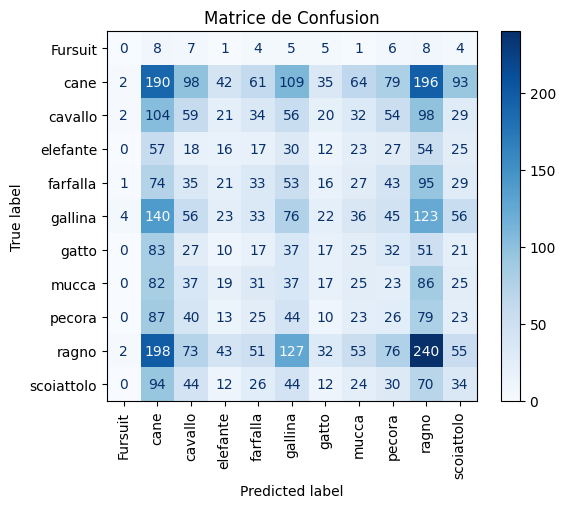

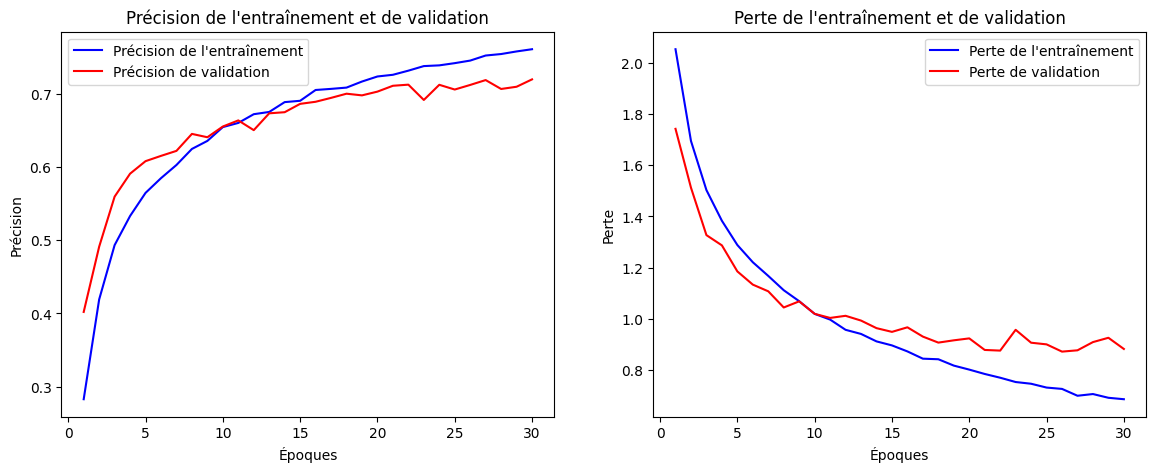

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py

# Fonction de prétraitement des images
def preprocess_image(image, label):
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image, label

# Chargement du dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TP2-images',
    image_size=(64, 64),
    batch_size=32,
    label_mode='int'
)

# Obtenir les noms des classes
class_names = dataset.class_names

dataset = dataset.map(preprocess_image)

# Nombre de classes (ajustez en fonction du nombre réel de classes)
NUM_CLASSES = 11

# Révision de l'architecture du modèle avec Dropout
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la première couche de convolution
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la deuxième couche de convolution
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la troisième couche de convolution
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout avant la couche dense finale
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Couche de sortie avec activation softmax
])

# Compilation du modèle
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Fonction pour diviser le dataset
def split_dataset(dataset, split_ratio=0.8):
    dataset_size = len(dataset)
    split_index = int(dataset_size * split_ratio)
    train_dataset = dataset.take(split_index)
    val_dataset = dataset.skip(split_index)
    return train_dataset, val_dataset

# Diviser les données
train_dataset, val_dataset = split_dataset(dataset)

# Entraîner le modèle
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30
)

# Sauvegarder le modèle
model1.save('model-C-1.h5')

# Ajouter les noms des classes dans le fichier HDF5
with h5py.File('model-C-1.h5', 'a') as f:
    f.attrs['class_names'] = np.string_(class_names)

# Évaluation du modèle
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)
val_predictions = np.argmax(model1.predict(val_dataset), axis=-1)

# Matrice de confusion
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matrice de Confusion')
plt.show()

# Graphique de précision et perte
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision de validation')
plt.title('Précision de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()
